# Inclined Plane

### Introduction

### What is it?

### Example

# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [1]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [2]:
%env MUJOCO_GL=egl

import os

# simulation
from dm_control import mjcf

# for video recording
import mediapy

# computations
import numpy as np

# plot charts
import seaborn as sns
import matplotlib.pyplot as plt

env: MUJOCO_GL=egl


Set nice theme for plots

In [3]:
sns.set_theme(style="whitegrid")

## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

In [4]:
# global
viscosity = 0.00002 # Air Resistance (this is default value for air on Earth)

# collision constants
length = 21  # [meters]
mass = 1  # [kg]
sphere_radius = 1

# rendering
width = 1280
height = 720
dpi = 600
duration = 10  # (seconds)
framerate = 60  # (Hz)

# project related
unit = os.getcwd().split("/")[-1]  # get the current directory
section = os.getcwd().split("/")[-2]  # get the current directory

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [5]:
import os, sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from scene import Scene

### Object

This class defines the object of our interest, an `inclined plane`. Here we write what is this object (inclined plane), what can it do (move, fall) and also add a camera that follows the object.

In [6]:
class Sphere(object):

    def __init__(self, size: float, mass: float) -> None:
        self.model = mjcf.RootElement(model="sphere")

        self.size = size / 2

        self.sphere = self.model.worldbody.add("body", name="sphere", pos=[0, 0, 0])
        self.sphere_geom = self.sphere.add(
            "geom",
            name="sphere_geom",
            type="sphere",
            size=[self.size],
            rgba=[0.1, 0.3, 0.7, 1],
            mass=mass,
        )

        self.rotate = self.sphere.add(
            "joint", name="rotate", type="hinge", axis=[0, 1, 0]
        )
        self.move = self.sphere.add("joint", name="move", type="slide", axis=[1, 0, 0])
        self.fall = self.sphere.add("joint", name="fall", type="slide", axis=[0, 0, 1])

        # tracking camera
        self.camera = self.sphere.add(
            "camera",
            name="front",
            pos=[0, -4, 0],
            euler=[90, 0, 0],
            mode="track",
        )

        self.sensor_site = self.sphere.add("site", pos=[0, 0, 0])
        self.model.sensor.add("velocimeter", name=f"velocity", site=self.sensor_site)

In [7]:
class InlinedPlane(object):

    def __init__(self, length: float) -> None:
        self.model = mjcf.RootElement(model="inclined_plane")

        self.degree = 15
        self.length = length / 2
        self.height = self.length * np.sin(np.deg2rad(self.degree))
        self.width = self.length * np.cos(np.deg2rad(self.degree))

        self.plane = self.model.worldbody.add("body", name="plane", pos=[0, 0, 0])
        self.plane_geom = self.plane.add(
            "geom",
            name="plane_geom",
            pos=[0, 0, self.height],
            type="box",
            size=[self.length, 0.5, 0.1],
            rgba=[1, 0, 0, 1],
            euler=[0, self.degree, 0],
            condim=1,
        )
        self.plane_2_geom = self.plane.add(
            "geom",
            name="plane_2_geom",
            pos=[self.length * np.sin(np.deg2rad(90 - self.degree)) + 1, 0, 0],
            type="box",
            size=[1, 0.5, 0.1],
            rgba=[1, 1, 0, 1],
            condim=1,
        )

        for i in range(0, 4):
            detector = self.plane = self.model.worldbody.add(
                "body",
                name=f"detector_{i}",
                pos=[
                    -self.length * np.cos(np.deg2rad(self.degree))
                    + length * np.cos(np.deg2rad(self.degree)) * i / 3,
                    0,
                    self.height * 2 * (3 - i) / 3,
                ],
                euler=[0, self.degree, 0],
            )
            detector.add(
                "geom",
                name=f"detector_bottom_{i}",
                pos=[0, 0, 0],
                type="box",
                size=[0.2, 0.55, 0.15],
                rgba=[1, 1, 0, 1],
                condim=1,
                conaffinity=2,
                contype=2,
            )
            detector.add(
                "geom",
                name=f"detector_top_{i}",
                pos=[0, 0, 0.5 + 0.1],
                type="box",
                size=[0.5, 0.5, 0.01],
                rgba=[0, 0, 0, 0.3],
                euler=[0, 90, 0],
                condim=1,
                conaffinity=2,
                contype=2,
            )
            sensor_site = detector.add("site", pos=[0, 0, 0.5 + 0.1])
            self.model.sensor.add("velocimeter", name=f"sense_{i}", site=sensor_site)

### World Model

Collecting everything into one general model

In [8]:
class Model(object):

    def __init__(self) -> None:
        self.model = mjcf.RootElement(model="model")

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width
        self.model.visual.map.znear = 0.001
        
        # set the simulation constants
        self.model.option.viscosity = viscosity
        self.model.option.integrator = "RK4"

        # create the scene (ground)
        self.scene = Scene(length=100)
        self.scene_site = self.model.worldbody.add("site", pos=[0, 0, 0])
        self.scene_site.attach(self.scene.model)

        # add the object
        self.inc_plane = InlinedPlane(length)
        inc_plane_site = self.model.worldbody.add(
            "site", pos=[self.inc_plane.width, 0, 0]
        )
        inc_plane_site.attach(self.inc_plane.model)

        # add the object
        self.sphere = Sphere(size=sphere_radius, mass=mass)
        sphere_site = self.model.worldbody.add(
            "site",
            pos=[
                0.15,
                0,
                length * np.sin(np.deg2rad(15)) + self.sphere.size + 0.1,
            ],
        )
        sphere_site.attach(self.sphere.model)

        # camera for rendering
        self.camera = self.model.worldbody.add(
            "camera",
            name="front",
            pos=[self.inc_plane.width, -2 * length / 2, length / 2],
            euler=[75, 0, 0],
            mode="fixed",
            fovy=45,
        )

## Simulation

Initializing the `physics` of the simulation

In [9]:
model = Model().model
physics = mjcf.Physics.from_mjcf_model(model)

""

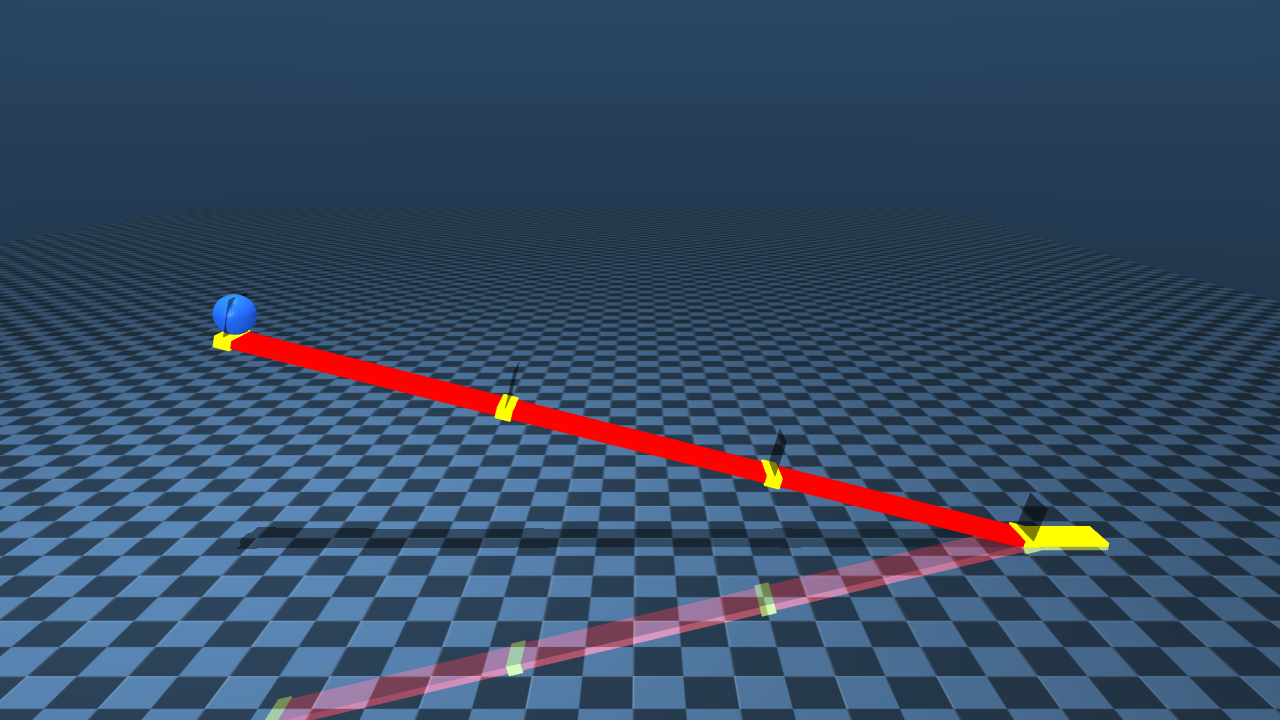

In [10]:
mediapy.show_image(physics.render(height, width, camera_id=0))

In [11]:
physics.named.data.qvel[1:]

array([0., 0.])

In [12]:
physics.bind(model.find_all("sensor")).sensordata

SynchronizingArrayWrapper([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                           0., 0., 0.])

In [13]:
model.find_all("sensor")

[MJCF Element: <velocimeter name="sense_0" site="//unnamed_site_0"/>,
 MJCF Element: <velocimeter name="sense_1" site="//unnamed_site_1"/>,
 MJCF Element: <velocimeter name="sense_2" site="//unnamed_site_2"/>,
 MJCF Element: <velocimeter name="sense_3" site="//unnamed_site_3"/>,
 MJCF Element: <velocimeter name="velocity" site="//unnamed_site_0"/>]

In [14]:
physics.bind(model.find("sensor", "sphere/velocity")).sensordata

SynchronizingArrayWrapper([0., 0., 0.])

In [15]:
sphere_id = physics.model.name2id("sphere/sphere_geom", "geom")
plane_id = physics.model.name2id("inclined_plane/plane_geom", "geom")
plane_2_id = physics.model.name2id("inclined_plane/plane_2_geom", "geom")
sensor_id = physics.model.name2id("inclined_plane/detector_top_2", "geom")
sphere_id, plane_id, plane_2_id, sensor_id

(11, 1, 2, 8)

### Simulation Loop

In [16]:
frames = []
timevals = []
velocity = []
position = []
sensor = []

physics.step()

drop = False
stop_measure = False
while physics.data.time < duration:

    if not drop:
        for i, c in enumerate(physics.data.contact):
            if sphere_id in c.geom and plane_id in c.geom:
                physics.named.data.qvel["sphere/fall"] = 0
                drop = True

    physics.step()

    for i, c in enumerate(physics.data.contact):
        if sphere_id in c.geom and sensor_id in c.geom:
            print(True)

        if sphere_id in c.geom and plane_2_id in c.geom:
            stop_measure = True

    if not stop_measure:
        timevals.append(physics.data.time)
        velocity.append(np.linalg.norm(physics.named.data.qvel[:].copy()))
        position.append(physics.named.data.geom_xpos["sphere/sphere_geom"][:].copy())
        sensor.append(
            physics.bind(
                model.find("sensor", "inclined_plane/sense_2")
            ).sensordata.copy()
        )

    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(width=width, height=height, camera_id=0)
        frames.append(pixels)

In [17]:
# Simulate and display video.
mediapy.show_video(frames, fps=framerate)

In [18]:
mediapy.write_video(f"../../output/inclined_plane.mp4", images=frames, fps=framerate)

## Simulation Data Visualization

Convert data into numpy array to have more features

In [19]:
velocity = np.array(velocity)
position = np.array(position)

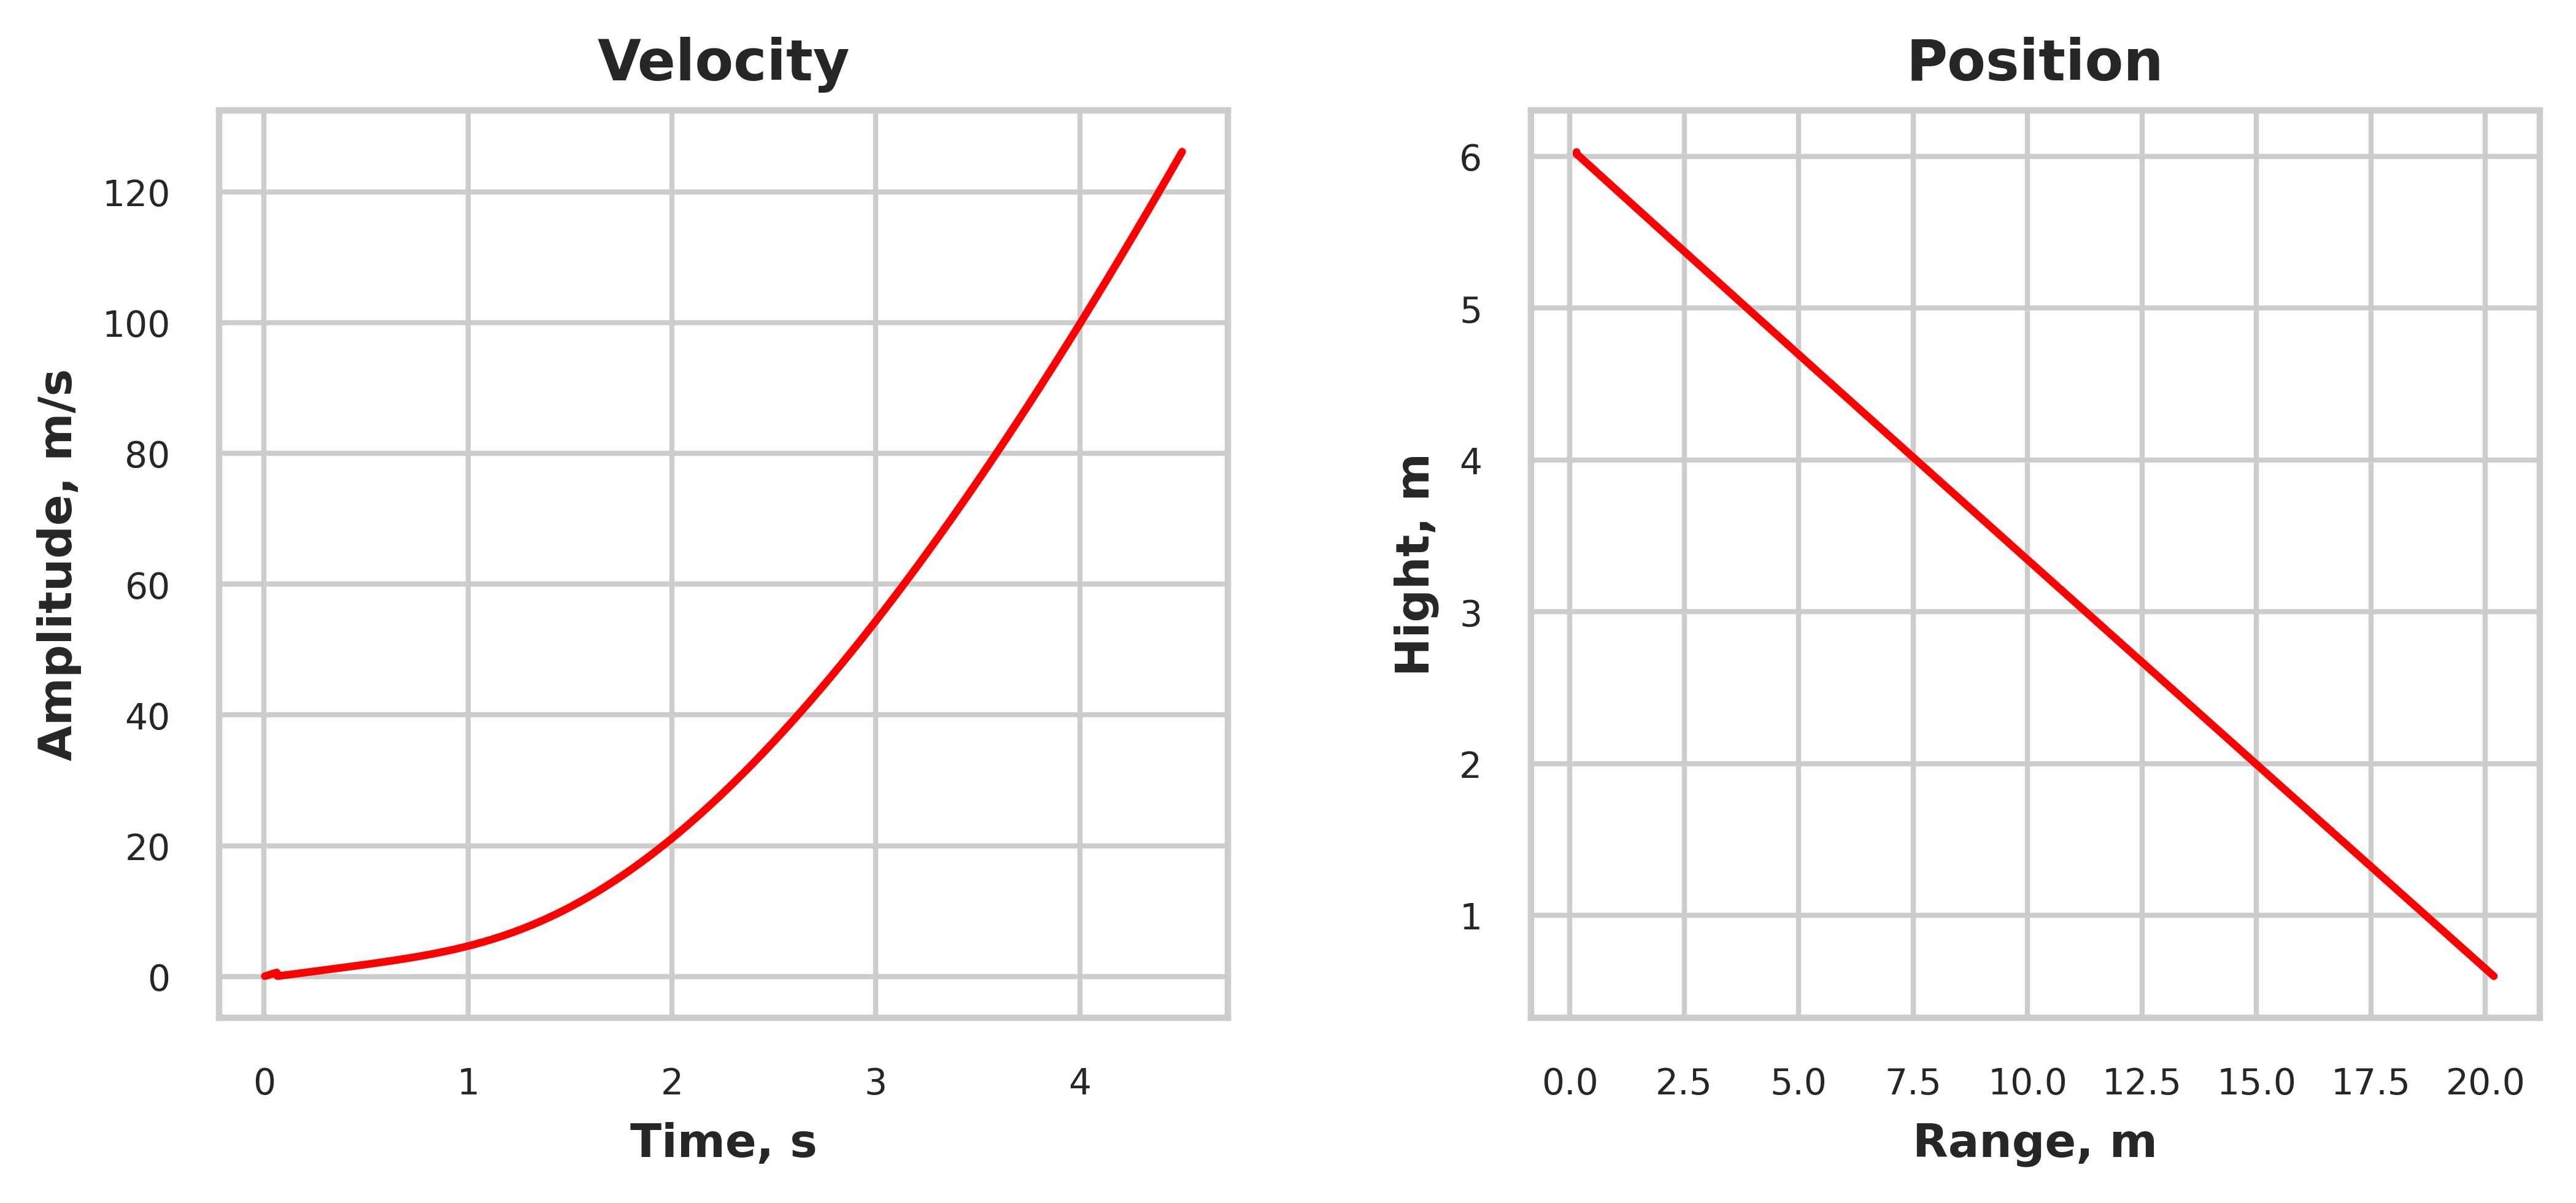

In [20]:
figsize = (width / dpi + 6, height / dpi + 2)
fig, ax = plt.subplots(ncols=2, figsize=figsize, dpi=dpi, sharex=False)
fig.subplots_adjust(wspace=0.3)

# position
sns.lineplot(x=position[:, 0], y=position[:, 2], ax=ax[1], color="red")
ax[1].set_title("Position", weight="bold", fontsize=11)
ax[1].set_ylabel("Hight, m", weight="bold", fontsize=9)
ax[1].set_xlabel("Range, m", weight="bold", fontsize=9)
ax[1].tick_params(labelsize=7)

# velocity
sns.lineplot(x=timevals, y=velocity, ax=ax[0], color="red")
ax[0].set_title("Velocity", weight="bold", fontsize=11)
ax[0].set_ylabel("Amplitude, m/s", weight="bold", fontsize=9)
ax[0].set_xlabel("Time, s", weight="bold", fontsize=9)
ax[0].tick_params(labelsize=7)

fig.savefig(f"../../output/inclined_plane.png", bbox_inches="tight")

In [21]:
velocity[-1]

np.float64(126.1430969431495)

In [22]:
velocity[-1] * np.sin(np.deg2rad(15))

np.float64(32.648235897100655)

In [23]:
9.81 * np.sin(np.deg2rad(15))

np.float64(2.5390148324557287)

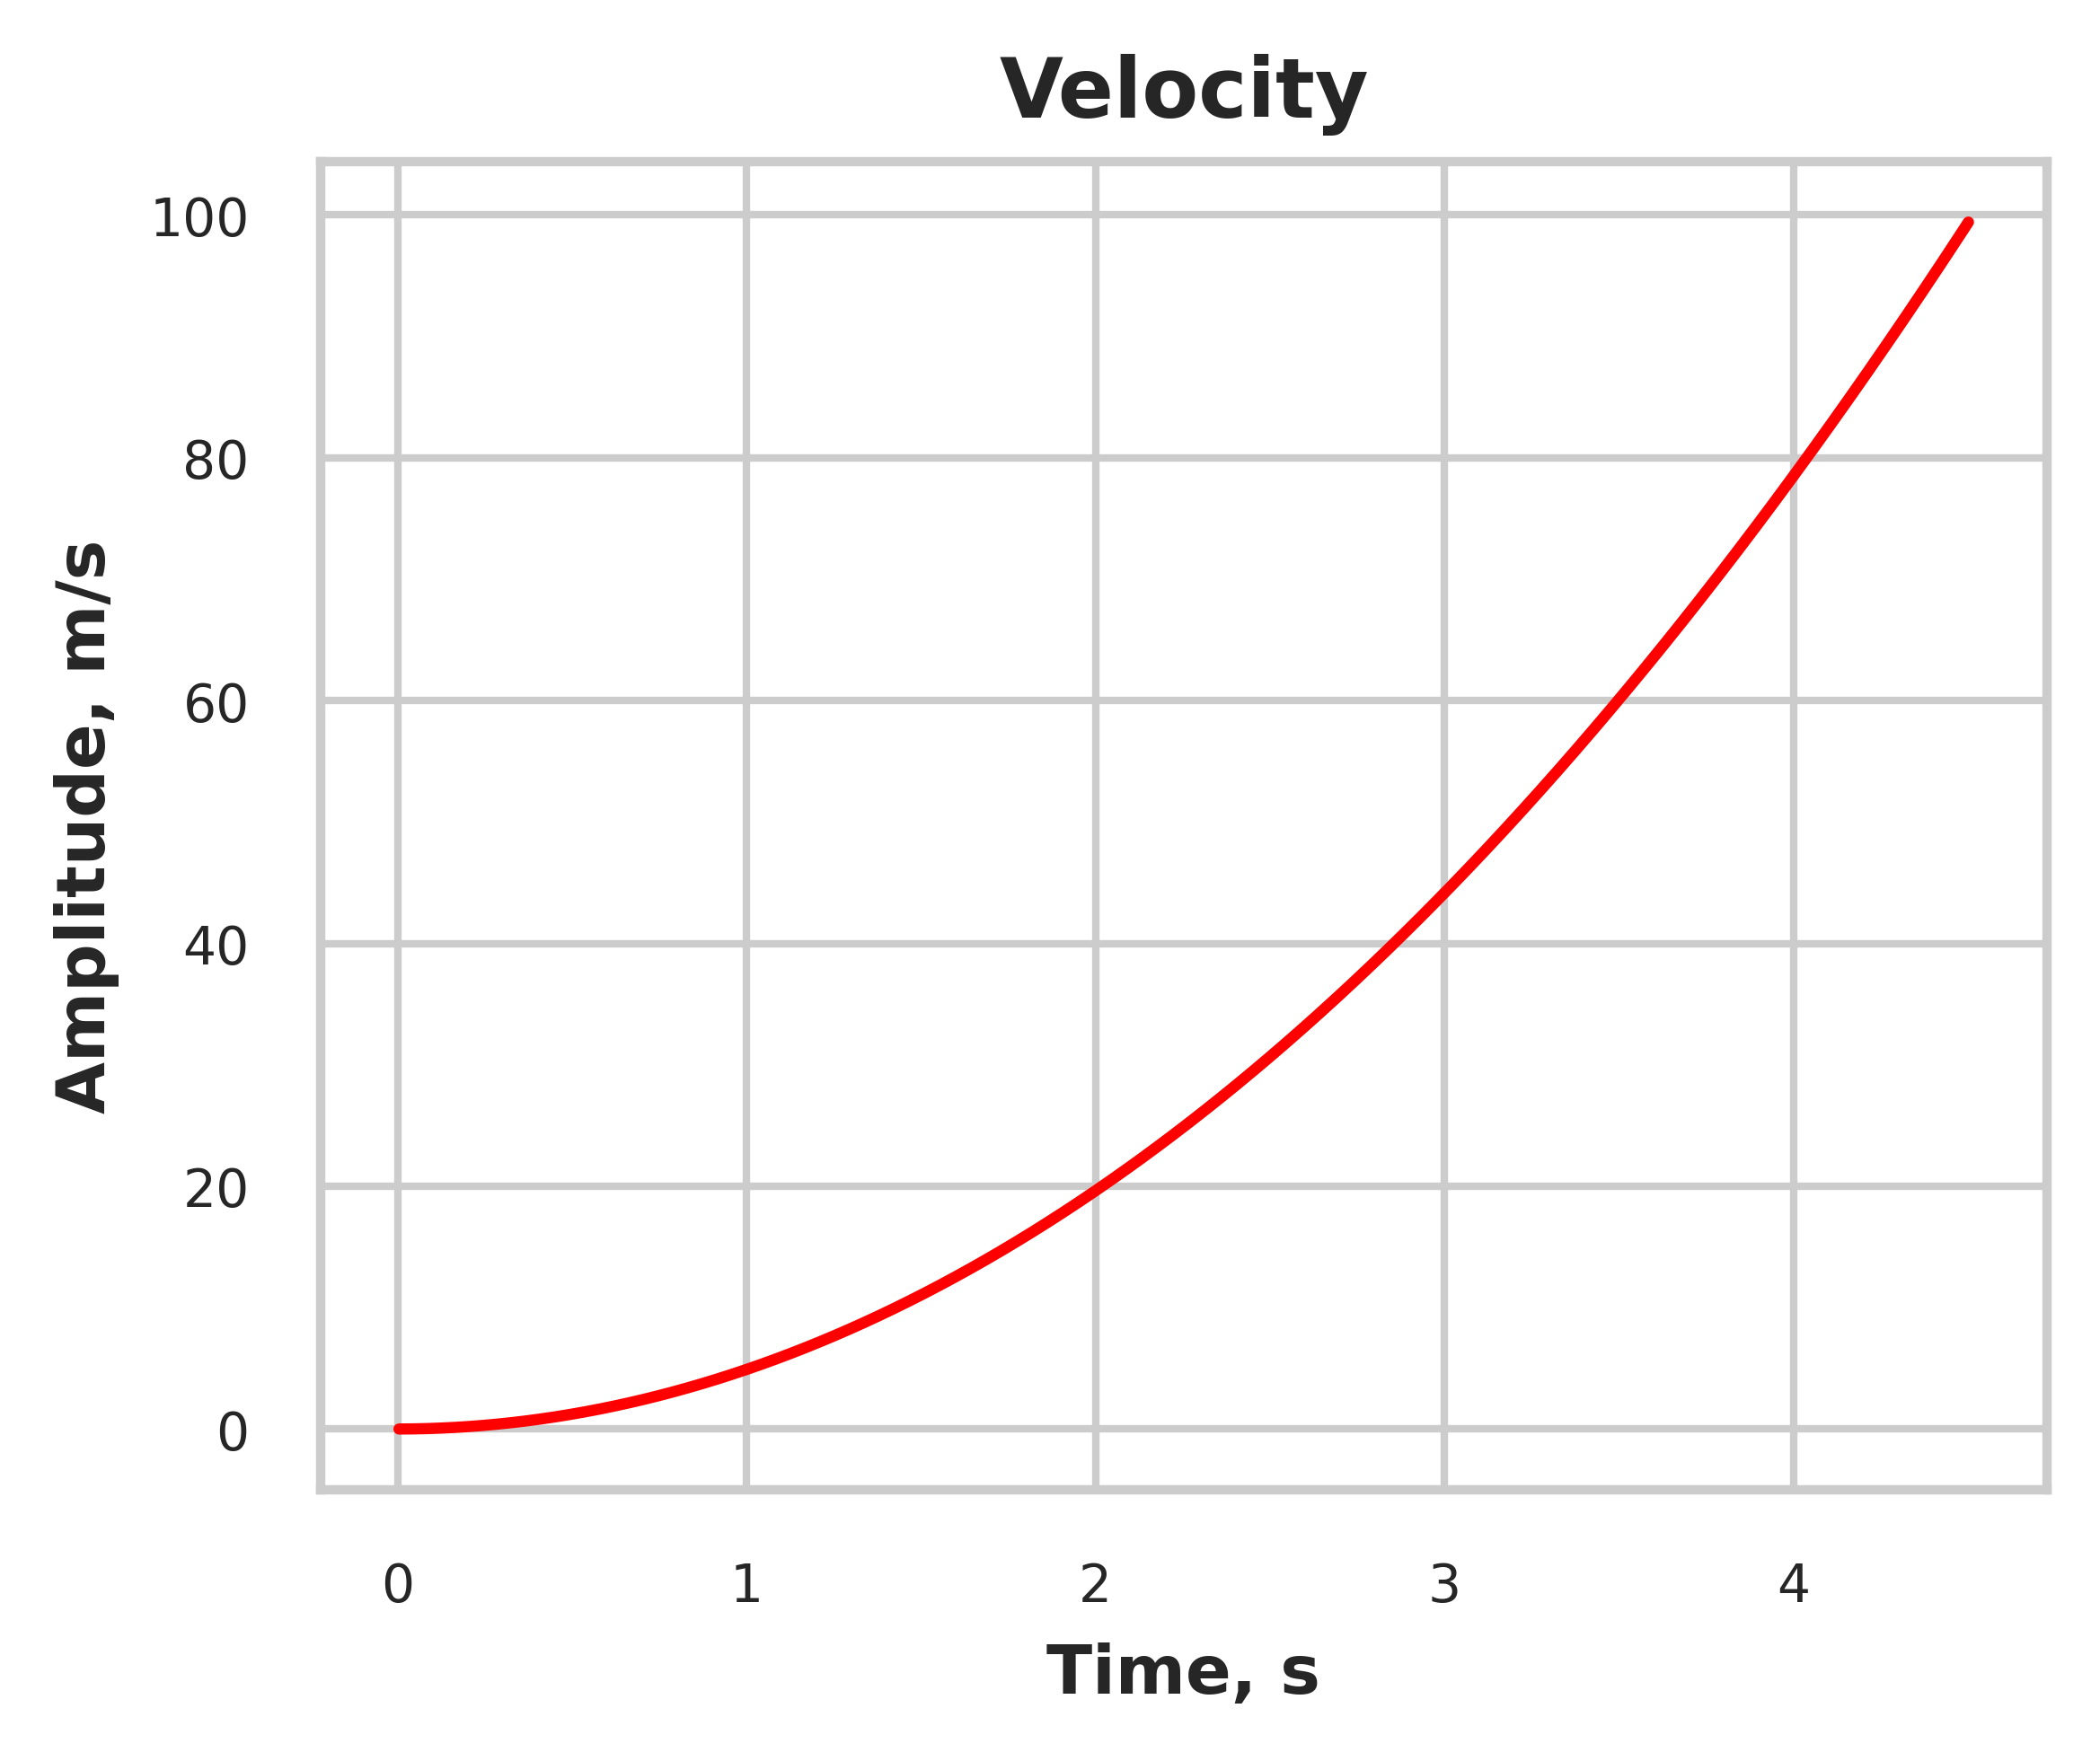

In [24]:
figsize = (width / dpi + 2, height / dpi + 2)
fig, ax = plt.subplots(ncols=1, figsize=figsize, dpi=dpi, sharex=False)
fig.subplots_adjust(wspace=0.3)

velocity_gravity = (
    1 / 2 * np.abs(physics.model.opt.gravity[-1]) * np.array(timevals) ** 2
)

# velocity
sns.lineplot(x=timevals, y=velocity_gravity, ax=ax, color="red")
ax.set_title("Velocity", weight="bold", fontsize=11)
ax.set_ylabel("Amplitude, m/s", weight="bold", fontsize=9)
ax.set_xlabel("Time, s", weight="bold", fontsize=9)
ax.tick_params(labelsize=7)

In [25]:
velocity_gravity[-1], velocity[-1]

(np.float64(99.41455961998791), np.float64(126.1430969431495))